<a href="https://colab.research.google.com/github/Manwi23/WILD/blob/ccolab/WILD_MLProjectReport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run the cells below if you want to experiment with the code yourself:

In [ ]:
!git clone https://github.com/Manwi23/WILD.git
%cd WILD
!git checkout ccolab
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver .

In [ ]:
from moreMeasurePoints import single_location, multi_location, current_weather
import pandas as pd
import scipy.stats as sstats
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt

# Section 1 - comparing different models

In this part we compare the performance of Ridge Regression, XGBoost and our small neural network on datasets that use different time intervals between measurements and use either data from Wrocław only (single_location) or Wrocław, Dresden, Poznan, Katowice and Praga (multi_location).

In each case, the task is the same - to predict the difference between the temperature 12h after - 12h before the last observation in Wrocław. In other words, we make a 12h temperature forecast, where temperature is encoded as the difference between the current temperature and temperature 24h ago.

**IMPORTANT** if you want to run the code in either Section 1 and Section 2, don't do it at the same time, as it might use all memory in Colab. Also, running them will take at least several minutes each.

In [ ]:
single_loc_models = single_location()

In [ ]:
multi_loc_models = multi_location()

In [ ]:
scores = []

for mgname, mgroup in [("single",single_loc_models), ("multi",multi_loc_models)]:
    for td in mgroup:
        for m in mgroup[td]:
            model = mgroup[td][m]
            # print(td//2, m)
            err = model.compute_errors(model.test_df)
            mu, sigma = sstats.norm.fit(err)
            lowerInterval = sstats.norm.ppf(0.10, mu, sigma)
            upperInterval = sstats.norm.ppf(0.90, mu, sigma)
            if m == "linear":
                scores.append([mgname, td//2, m, model.compute_score(model.train_df), 0, model.compute_score(model.test_df),  upperInterval- lowerInterval])
            else:
                scores.append([mgname, td//2, m, model.compute_score(model.train_df), model.compute_score(model.val_df), model.compute_score(model.test_df),  upperInterval- lowerInterval])

scores_df = pd.DataFrame(scores, columns=["locations", "time delta", "model", "train", "validation", "test", "confidence interval (80%) width"])
scores_df.sort_values("test", ascending=False)

locations  time delta  ...      test  confidence interval (80%) width
23     multi           6  ...  0.442866                         6.712424
20     multi           4  ...  0.423077                         6.818243
26     multi          12  ...  0.422009                         6.763336
19     multi           4  ...  0.408797                         6.907582
25     multi          12  ...  0.399417                         6.892819
11    single          12  ...  0.384746                         7.128584
21     multi           6  ...  0.382178                         7.053950
5     single           4  ...  0.381706                         7.130018
24     multi          12  ...  0.379142                         6.983328
22     multi           6  ...  0.365179                         7.161217
18     multi           4  ...  0.363991                         7.151861
8     single           6  ...  0.354485                         7.295867
10    single          12  ...  0.345085                         7.353416
7     single           6  ...  0.336589                         7.395765
9     single          12  ...  0.320142                         7.493541
4     single           4  ...  0.306618                         7.550639
17     multi           2  ...  0.288652                         7.577398
29     multi          24  ...  0.275112                         7.475877
6     single           6  ...  0.253411                         7.844718
3     single           4  ...  0.246960                         7.866749
16     multi           2  ...  0.221683                         7.926576
2     single           2  ...  0.211859                         8.050993
27     multi          24  ...  0.206436                         7.825288
15     multi           2  ...  0.192055                         8.070736
28     multi          24  ...  0.190624                         7.903979
12    single          24  ...  0.184317                         8.019542
14    single          24  ...  0.182383                         8.027849
0     single           2  ...  0.175865                         8.226903
1     single           2  ...  0.116879                         8.522732
13    single          24  ...  0.101418                         8.415536

[30 rows x 7 columns]

Train, validation and test scores are computed as follows: 

$score = \frac{MSE(prediction, target)}{MSE(mean(target), target)}$

Time delta is shown in hours, confidence bounds are in degrees Celsius.

Observations:
*   Neural nets outperform both XGBoost and Ridge regression. 
*   Models trained on multilocation data perform better.
*   Models trained on data with 2h and 24h intervals perform much worse than others - this is because they don't include the data from 24h before the target time, which is the most important predictor.



The problem is quite difficult and the differences between the best and worst model are quite slim, as presented on the histogram below.

Errors on test data - best and worst model


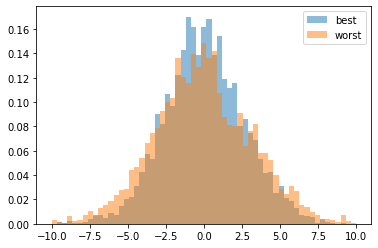

In [ ]:
best_model = multi_loc_models[12]["neuralnet"]
worst_model = single_loc_models[48]["xgboost"]

best_err = best_model.compute_errors(best_model.test_df)
worst_err = worst_model.compute_errors(worst_model.test_df)

bins = np.linspace(-10, 10, 60)

pyplot.hist(best_err, bins, alpha=0.5, label='best', density=True)
pyplot.hist(worst_err, bins, alpha=0.5, label='worst', density=True)
pyplot.legend(loc='upper right')
print("Errors on test data - best and worst model")
pyplot.show()

Errors on train data - best and worst model


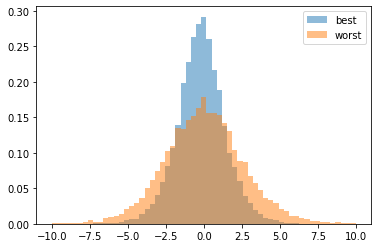

In [ ]:
best_err = best_model.compute_errors(best_model.train_df)
worst_err = worst_model.compute_errors(worst_model.train_df)

bins = np.linspace(-10, 10, 60)

pyplot.hist(best_err, bins, alpha=0.5, label='best', density=True)
pyplot.hist(worst_err, bins, alpha=0.5, label='worst', density=True)
pyplot.legend(loc='upper right')
print("Errors on train data - best and worst model")
pyplot.show()

Errors on test and train data- best model


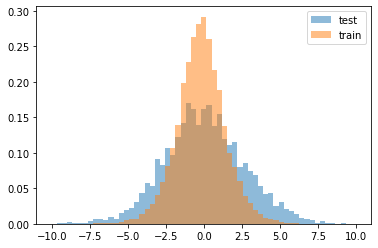

In [ ]:
best_test_err = best_model.compute_errors(best_model.test_df)
best_train_err = best_model.compute_errors(best_model.train_df)

bins = np.linspace(-10, 10, 60)

pyplot.hist(best_test_err, bins, alpha=0.5, label='test', density=True)
pyplot.hist(best_train_err, bins, alpha=0.5, label='train', density=True)
pyplot.legend(loc='upper right')
print("Errors on test and train data- best model")
pyplot.show()

# Section 2 - live prediction

You can run all the cells below to see the comparison between selected models on live data. 

In [ ]:
models = multi_location(rain=False)

In [ ]:
ans, true_value = current_weather(models, multiple_locations=["wroclaw", "poznan", "katowice", "prague", "dresden"])

This plot shows the model prediction overlaid with the true data from the last 6 calendar days. 

X axis units are 30min, Y axis are degrees Celsius. The "ground truth" line represents the true values at given time (the value model is trying to predict), the "same as 24 hours ago" shows the result of a dummy model that always predicts 0 in our encoding, in other words assumes the temperature will be the same as it was 24 hours ago.

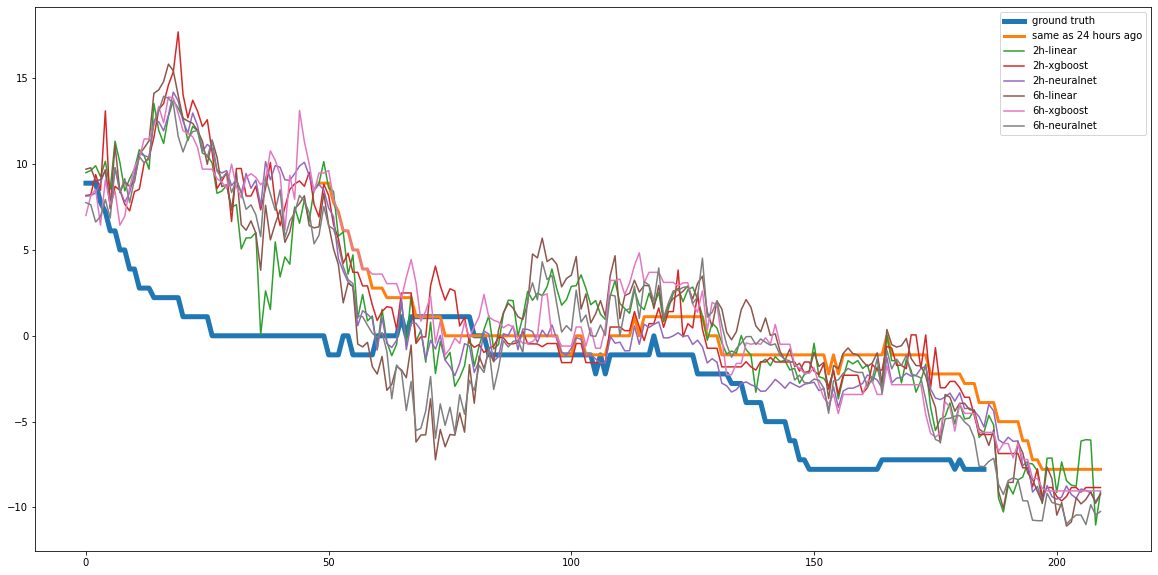

In [7]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(true_value.to_numpy()[-210+24:], label=f"ground truth", linewidth=5)
plt.plot(range(48,210), true_value.to_numpy()[-210+24:-24], label=f"same as 24 hours ago", linewidth=3)


for td in [4,12]:
    for m in ans[td]:
        plt.plot(ans[td][m][-210:], label=f"{td//2}h-{m}")
plt.legend()
plt.show()

This line prints the decoded output of our best model for the most recent weather data and predicts what will be the temperature in 12 hours in degrees Celsius.

In [9]:
print("In 12 hours, the temperature will be", ans[12]["neuralnet"][-1])

In 12 hours, the temperature will be -10.234820710288155
